In [3]:
%matplotlib inline


# NLP From Scratch: Generating Names with a Character-Level RNN
**Author**: [Sean Robertson](https://github.com/spro)

This is our second of three tutorials on "NLP From Scratch".
In the [first tutorial](/intermediate/char_rnn_classification_tutorial)
we used a RNN to classify names into their language of origin. This time
we'll turn around and generate names from languages.

```sh
> python sample.py Russian RUS
Rovakov
Uantov
Shavakov

> python sample.py German GER
Gerren
Ereng
Rosher

> python sample.py Spanish SPA
Salla
Parer
Allan

> python sample.py Chinese CHI
Chan
Hang
Iun
```
We are still hand-crafting a small RNN with a few linear layers. The big
difference is instead of predicting a category after reading in all the
letters of a name, we input a category and output one letter at a time.
Recurrently predicting characters to form language (this could also be
done with words or other higher order constructs) is often referred to
as a "language model".



## Preparing the Data

<div class="alert alert-info"><h4>Note</h4><p>Download the data from
   [here](https://download.pytorch.org/tutorial/data.zip)
   and extract it to the current directory.</p></div>

See the last tutorial for more detail of this process. In short, there
are a bunch of plain text files ``data/names/[Language].txt`` with a
name per line. We split lines into an array, convert Unicode to ASCII,
and end up with a dictionary ``{language: [names ...]}``.



# 기초부터 시작하는 NLP:  문자-단위 RNN으로 이름 생성하기

우리는 몇 개의 선형 계층으로 작은 RNN을 직접 만들고 있습니다.
이전 튜토리얼인 이름을 읽은 후 그 언어를 예측하는 것과의 큰 차이점은
언어를 입력하고 한 번에 한 글자를 생성하여 출력하는 것입니다.
언어 형성(단어 또는 다른 고차원 구조로도 수행될 수 있음)을 위해
문자를 반복적으로 예측하는 것을 "언어 모델" 이라고 합니다.




In [1]:
import os, zipfile
from pathlib import Path

with zipfile.ZipFile("data.zip", "r") as zip_ref:
    zip_ref.extractall()

In [6]:
from io import open
import glob, os, unicodedata, string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file a split into lines
def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['German', 'Portuguese', 'Czech', 'Vietnamese', 'Russian', 'Irish', 'Japanese', 'Korean', 'Dutch', 'French', 'Arabic', 'Polish', 'Greek', 'Chinese', 'Scottish', 'English', 'Italian', 'Spanish']
O'Neal


## Creating the Network

This network extends [the last tutorial's RNN](#Creating-the-Network)_
with an extra argument for the category tensor, which is concatenated
along with the others. The category tensor is a one-hot vector just like
the letter input.

We will interpret the output as the probability of the next letter. When
sampling, the most likely output letter is used as the next input
letter.

I added a second linear layer ``o2o`` (after combining hidden and
output) to give it more muscle to work with. There's also a dropout
layer, which [randomly zeros parts of its
input](https://arxiv.org/abs/1207.0580)_ with a given probability
(here 0.1) and is usually used to fuzz inputs to prevent overfitting.
Here we're using it towards the end of the network to purposely add some
chaos and increase sampling variety.






## 네트워크 생성

이 네트워크는 [지난 튜토리얼의 RNN](#Creating-the-Network)_ 이
다른 입력들과 연결되는 category tensor를 추가 인자로 가지게 확장합니다.
category tensor는 문자 입력과 마찬가지로 one-hot 벡터입니다.

역자주: 기존 입력과 category tensor를 결합하여 입력으로 사용하기 때문에
입력의 사이즈가 n_categories 만큼 커집니다.

우리는 출력을 다음 문자의 확률로 해석합니다. 샘플링 할 때,
가장 확률이 높은 문자가 다음 입력 문자로 사용됩니다.

더 나은 동작을 위해 두 번째 선형 레이어
``o2o`` (은닉과 출력을 결합한 후) 를 추가했습니다 .
또한 Drop-out 계층이 있습니다. 이 계층은 주어진 확률(여기서는 0.1)로
[무작위로 입력을 0 #](https://arxiv.org/abs/1207.0580)_ 으로 만듭니다.
일반적으로 입력을 흐리게 해서 과적합을 막는 데 사용됩니다.
여기서 우리는 고의로 일부 혼돈을 추가하고 샘플링 다양성을 높이기
위해 네트워크의 마지막에 이것을 사용합니다.

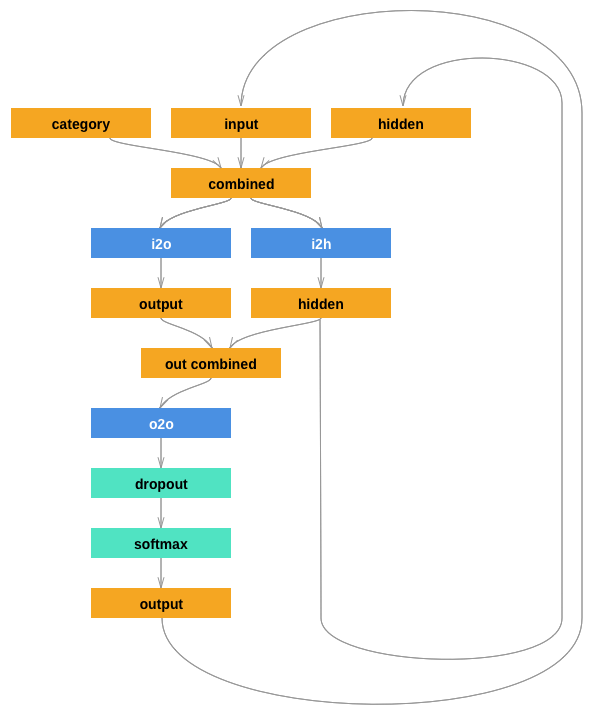



In [4]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

## Training
Preparing for Training
----------------------

First of all, helper functions to get random pairs of (category, line):




## 학습
학습 준비
----------------------

제일 먼저 (category, line)의 무작위 쌍을 얻는 함수:




In [5]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

For each timestep (that is, for each letter in a training word) the
inputs of the network will be
``(category, current letter, hidden state)`` and the outputs will be
``(next letter, next hidden state)``. So for each training set, we'll
need the category, a set of input letters, and a set of output/target
letters.

Since we are predicting the next letter from the current letter for each
timestep, the letter pairs are groups of consecutive letters from the
line - e.g. for ``"ABCD<EOS>"`` we would create ("A", "B"), ("B", "C"),
("C", "D"), ("D", "EOS").

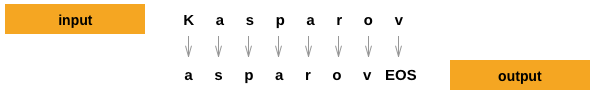

The category tensor is a [one-hot
tensor](https://en.wikipedia.org/wiki/One-hot)_ of size
``<1 x n_categories>``. When training we feed it to the network at every
timestep - this is a design choice, it could have been included as part
of initial hidden state or some other strategy.




각 시간 단계 마다 (즉, 학습 단어의 각 문자 마다) 네트워크의 입력은
``(언어, 현재 문자, 은닉 상태)`` 가 되고, 출력은
``(다음 문자, 다음 은닉 상태)`` 가 된다. 따라서 각 학습 세트 마다
언어, 입력 문자의 세트, 출력/목표 문자의 세트가 필요하다.

각 시간 단계마다 현재 문자에서 다음 문자를 예측하기 때문에,
문자 쌍은 한 줄(하나의 이름)에서 연속된 문자 그룹입니다. - 예를 들어 ``"ABCD<EOS>"`` 는
("A", "B"), ("B", "C"), ("C", "D"), ("D", "EOS") 로 생성합니다.


Category(언어) Tensor는 ``<1 x n_categories>`` 크기의 [One-hot
Tensor](https://en.wikipedia.org/wiki/One-hot)_ 입니다.
학습시에 모든 시간 단계에서 네트워크에 이것을 전달합니다.
- 이것은 설계 선택사항으로, 초기 은닉 상태 또는
또 다른 전략의 부분으로 포함될 수 있습니다.




In [7]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# ``LongTensor`` of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

For convenience during training we'll make a ``randomTrainingExample``
function that fetches a random (category, line) pair and turns them into
the required (category, input, target) tensors.




학습 동안 편의를 위해 무작위로 (category[언어], line[이름])을 가져오고
그것을 필요한 형태 (category[언어], input[현재 문자], target[다음 문자]) Tensor로 바꾸는
``randomTrainingExample`` 함수를 만들 예정입니다.




In [8]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

### Training the Network

In contrast to classification, where only the last output is used, we
are making a prediction at every step, so we are calculating loss at
every step.

The magic of autograd allows you to simply sum these losses at each step
and call backward at the end.




### 네트워크 학습

마지막 출력만 사용하는 분류와 달리, 모든 단계에서 예측을 수행하므로
모든 단계에서 손실을 계산합니다.

Autograd의 마법이 각 단계의 손실들을 간단하게 합하고 마지막에
역전파를 호출하게 해줍니다.




In [9]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = torch.Tensor([0]) # you can also just simply use ``loss = 0``

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha = - learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

To keep track of how long training takes I am adding a
``timeSince(timestamp)`` function which returns a human readable string:




학습에 걸리는 시간을 추적하기 위해 사람이 읽을 수 있는 문자열을
반환하는``timeSince (timestamp)`` 함수를 추가합니다:




In [10]:
import time, math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

Training is business as usual - call train a bunch of times and wait a
few minutes, printing the current time and loss every ``print_every``
examples, and keeping store of an average loss per ``plot_every`` examples
in ``all_losses`` for plotting later.




학습은 일상적인 일입니다. - 몇 번 train() 을 호출하고, 몇 분 정도
기다렸다가 ``print_every`` 마다 현재 시간과 손실을 출력하고,
나중에 도식화를 위해  ``plot_every`` 마다 ``all_losses`` 에
평균 손실을 저장합니다.




In [11]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every ``plot_every`` ``iters``

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 19s (5000 5%) 3.2074
0m 39s (10000 10%) 2.6935
0m 58s (15000 15%) 2.2066
1m 19s (20000 20%) 2.5244
1m 38s (25000 25%) 3.2433
2m 1s (30000 30%) 2.3575
2m 33s (35000 35%) 2.5780
3m 10s (40000 40%) 1.9919
3m 33s (45000 45%) 2.2552
3m 54s (50000 50%) 2.4114
4m 15s (55000 55%) 2.0644
4m 36s (60000 60%) 2.1382
5m 7s (65000 65%) 2.6424
5m 34s (70000 70%) 2.6864
6m 8s (75000 75%) 2.1215
6m 45s (80000 80%) 2.5942
7m 12s (85000 85%) 1.6538
7m 33s (90000 90%) 1.7613
7m 59s (95000 95%) 2.9058
8m 34s (100000 100%) 2.0954


### Plotting the Losses

Plotting the historical loss from all\_losses shows the network
learning:




### 손실 도식화

all\_losses를 이용한 손실의 도식화는
네트워크의 학습 상태를 보여줍니다:




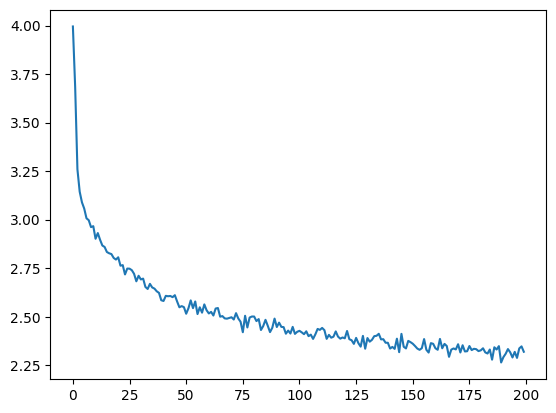

In [13]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses);

## Sampling the Network

To sample we give the network a letter and ask what the next one is,
feed that in as the next letter, and repeat until the EOS token.

-  Create tensors for input category, starting letter, and empty hidden
   state
-  Create a string ``output_name`` with the starting letter
-  Up to a maximum output length,

   -  Feed the current letter to the network
   -  Get the next letter from highest output, and next hidden state
   -  If the letter is EOS, stop here
   -  If a regular letter, add to ``output_name`` and continue

-  Return the final name

<div class="alert alert-info"><h4>Note</h4><p>Rather than having to give it a starting letter, another
   strategy would have been to include a "start of string" token in
   training and have the network choose its own starting letter.</p></div>




## 네트워크 샘플링

샘플링을 위해서, 네트워크에 하나의 글자를 주고 다음 문자를 물어보고
이것을 다음 문자로 전달하는 것을 EOS 토큰까지 반복합니다.

-  입력 카테고리(언어), 시작 문자, 비어 있는 은닉 상태를 위한 Tensor를 생성하십시오
-  시작 문자로 ``output_name`` 문자열을 생성하십시오
-  최대 출력 길이까지,

   -  현재 문자를 네트워크에 전달하십시오.
   -  가장 높은 출력에서 다음 문자와 다음 은닉 상태를 얻으십시오
   -  만일 문자가 EOS면, 여기서 멈추십시오
   -  만일 일반적인 문자라면, ``output_name`` 에 추가하고 계속하십시오

-  마지막 이름을 반환하십시오

.. Note::
   시작 문자를 주는 것 외에 "문자열 시작" 토큰을 학습에
   포함되게 하고 네트워크가 자체적으로 시작 문자를 선택하게 하는
   다른 방법도 있습니다.




In [14]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad(): # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

samples('Korean', 'PKL')

Rourov
Uanier
Shinovev
Gerter
Ereng
Roure
Salla
Pares
Arter
Chan
Han
Iun
Pon
Kon
Lon


## Exercises

-  Try with a different dataset of category -> line, for example:

   -  Fictional series -> Character name
   -  Part of speech -> Word
   -  Country -> City

-  Use a "start of sentence" token so that sampling can be done without
   choosing a start letter
-  Get better results with a bigger and/or better shaped network

   -  Try the ``nn.LSTM`` and ``nn.GRU`` layers
   -  Combine multiple of these RNNs as a higher level network


